Если интересно продолжать работать с NLP, то можно посмотреть вот это:

https://neurohive.io/ru/novosti/bert-ot-google-ai-open-source-model-obrabotki-estestvennogo-jazyka/

https://proglib.io/p/fun-nlp/

https://github.com/google-research/bert (можно попробовать обучить на русском языке на этом датасете: https://raw.githubusercontent.com/Koziev/NLP_Datasets/master/QA/premise_question_answer5.txt)

# Введение

Сегодня отойдем от темы обработки естественного языка и поговорим о картинках и видео. Сначала расскажу, что можно делать и каким образом, а потом попробуем что-нибудь пораспознавать.

С изображениями можно решать несколько классов задач (некоторые из них): 

Распознавание изображений

Трекинг объектов

Сегментация изображений

На сегодняшний день существует куча интересных проектов, в которых фигурируют картинки и deep learning. Допустим, вы можете составить 3д-модель головы определенного человека по всего нескольким фотографиям (https://neurohive.io/ru/papers/rekonstrukcija-3d-modeli-golovy/), научиться по видео определять говорящего и убирать звук на фоне (https://neurohive.io/ru/novosti/kontroliruemoe-obuchenie-rnn/; https://github.com/google/uis-rnn). А можно даже задетектить рак (https://neurohive.io/ru/novosti/nejronnaja-set-ot-google-ai-vyjavljaet-rakovye-metastazy-s-tochnostju-99/).

# Теория

Самое основное, о чем тут можно говорить, это сверточые нейронные сети. Их применяют почти везде, где требуется что-то сделать с картинками.

Итак, рассмотрим схему сверточной нейронной сети:
![alt text](http://www.trivialorwrong.com/assets/laws-sausages-and-convnets_files/convnet-example.png)

Это более-менее типичный пример сверточной нейронной сети. Здесь мы видим несколько надписей:

1. Conv
2. Maxpool
3. Non-linear
4. Fully-connected

Получается, что в CNN есть. как минимум 4 вида слоев:

1. Сверточный (Convolution)
2. Подвыборка (Subsampling)
3. ReLu-слой
4. Обычный, полносвязный слой



И суть следующая: вы подаете на входы сети изображение и оно проходит через различные комбинации этих четырех слоев, а на выходе вы получаете класс этого изображения

## Сверточный слой

Чтобы понять, что такое сверточный слой, нам нужно понять, что такое **свертка изображения с матрицей** (или свертка матриц).

Так вот, грубо говоря, у нас есть матрица свертки размером 3 на 3 (то есть просто каких-то 9 чисел, которые мы взяли из головы) и есть входное изображение. И мы берем нашу матрицу свертки и "сворачиваем" ее со всеми кусочками нашего входного изображения размером 3 на 3.![alt text](https://mlnotebook.github.io/img/CNN/convZeros.png)
То есть мы берем нашу матрицу 3 на 3 и накладываем ее на все возможные участки картинки. После каждого накладывания мы получаем одно какое-то число и записываем его в отдельный массив. Этот отдельный массив будем называть **картой признака** (или **feature map**) Карта признака на картинке выше - синяя матрица, если че.

Попробуем теперь что-то свернуть... Для этого скачаем картинку из интернета

In [1]:
!wget https://cdn.forums.klei.com/monthly_07_2013/post-17183-13764597435168_thumb.jpg

--2018-11-24 09:30:03--  https://cdn.forums.klei.com/monthly_07_2013/post-17183-13764597435168_thumb.jpg
Resolving cdn.forums.klei.com (cdn.forums.klei.com)... 54.230.118.77, 54.230.118.117, 54.230.118.71, ...
Connecting to cdn.forums.klei.com (cdn.forums.klei.com)|54.230.118.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8924 (8.7K) [image/jpeg]
Saving to: ‘post-17183-13764597435168_thumb.jpg’

post-17183-13764597 100%[===================>]   8.71K  --.-KB/s    in 0s      

2018-11-24 09:30:04 (17.3 MB/s) - ‘post-17183-13764597435168_thumb.jpg’ saved [8924/8924]



In [2]:
!ls

post-17183-13764597435168_thumb.jpg  sample_data


И отобразим ее на экране нашего notebook.

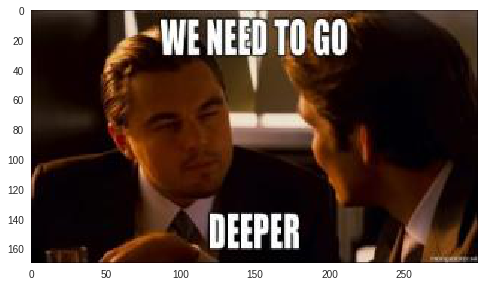

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
img = mpimg.imread('post-17183-13764597435168_thumb.jpg') # читаем картинку
plt.grid(None) # убираем сетку с изображения
imgplot = plt.imshow(img) # отображаем

Разделим нашу картинку по каналам, чтобы получить из нее три матрицы (если че, то картинка имеет три цветовых канала: RGB, то есть картинка  - это недвумерная штука, а трехмерная). Мы возьмем каждую составляющую и свернем ее с отдельной матрицей свертки. То есть 

channel_R \* mtr_R,

channel_G \* mtr_G,

channel_B \* mtr_B, 

"*" - операция свертки

А после свертки объединим наши карты признаков в одно изображение.

In [0]:
img_chnls = np.split(img, 3, axis=2)

Матрицы свертки для каждой составляющей

In [0]:
mtx_R = [[1, 0, 0],
        [0, 2, 0],
        [0, 0, 1]]

mtx_G = [[0, 1, 0],
        [0, 2, 0],
        [0, 1, 0]]

mtx_B = [[0, 0, 0],
        [1, 2, 1],
        [0, 0, 0]]

Функция свертки

In [0]:
def conv(img, mtx):
    res = np.ndarray(img.shape)
    img = np.pad(img, pad_width=1, mode='constant', constant_values=0) # добавляем рамку из нулей вокруг изображения, чтобы свертка не уменьшала его
    for y in range(1, img.shape[0]-1):
        for x in range(1, img.shape[1]-1):
            roi = img[y-1:y+2, x-1:x+2]
            res[y-1, x-1] = np.multiply(roi, mtx).sum() # перемножаем элементы первой и второй матрицы соответсвенно и находим сумму результатов
            
    return res
                    

Сворачиваем... 

Замечание. Обратите внимание, что за красную составляющую мы приняли последний канал картинки, а не первый (то есть у нас картинка BGR, а не RGB)


In [0]:
fm_R = conv(img_chnls[2], mtx_R)
fm_G = conv(img_chnls[1], mtx_G)
fm_B = conv(img_chnls[0], mtx_B)

In [23]:
img.shape

(170, 300, 3)

Нормализуем получившиеся фичермапы и объединяем в картинку

In [0]:
fm_R = np.divide(fm_R, fm_R.max())
fm_G = np.divide(fm_G, fm_G.max())
fm_B = np.divide(fm_B, fm_B.max())

conv_img = np.ndarray(img.shape)
conv_img[:,:,0] = fm_B[:,:,0]
conv_img[:,:,1] = fm_G[:,:,0]
conv_img[:,:,2] = fm_R[:,:,0]

Рисуем

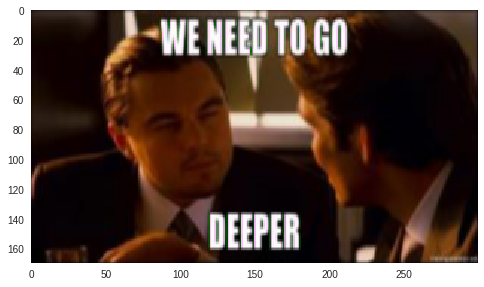

In [26]:
plt.grid(None)
imgplot = plt.imshow(conv_img) # отображаем

Не знаю заметили ли вы или нет, но когда мы нормализовали наши фичемапы, то мы привели их только к значениям от 0 до 1. Хотя стоило бы привести их к виду от 0 до 255. Но у matplotlib есть такая особенность, что она умеет отображать картинки, заданные вещественными числами от 0 до 1. Вот, поэтому в этом нет необхоимости.

Ну и вот. Получили размытое изображение (причем размыли по-разному на разных каналах)

## Подвыборка
